# Описание

Итоговое решение задачи A. "Будь здоров", олимпиады RuCode Start 2024. С этим решением мы заняли 2 место. Значение метрики F1 macro на открытом наборе данных: 66.31, на закрытом: 64.68. 

Команда "pip":
- Мой Github: https://github.com/Lex-TS, 
- Github сокомандника: https://github.com/Lebedkina 

В ноутбуке можно заметить, что модель обучается на данных, смешанных с синтетически сгенерированными, а после чего проверяет качество на тестовой выборке с такими же частично ненастоящими данными. Это приводит к так называемой утечке данных, модель переобучается и выдает после обучения значение метрики F1 macro около 0.8 на тестовой выборке. 

Нам следовало бы сначала разделить набор данных на тестовую и обучающую, а уже потом применять SMOTE-NC для генерации данных и уравнивания классов. 

Для решения задачи классификации здесь используется модель CatBoostClassifier, а также в качестве предобработки данных - алгоритм передискретизации SMOTE-NC для уравнивания количества экземпляров класса.

# Основное решение

## Ввод данных и библиотек

Внимание

Данное решение требует наличия версии imblearn 0.12.2, catboost 1.2.5, если библиотеки будут старее (особенно imblearn), то результаты преобразования данных и обучения будут другими. Запускалось в Visual Studio Code 1.89.1 с расширением Jupyter v2024.4.0 на python 3.11.5

In [ ]:
#%pip install imblearn
#%pip install catboost==1.2.3

In [1]:
import numpy as np
import pandas as pd
import catboost
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
%matplotlib inline

In [2]:
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
#print('numpy:',np.__version__)
#print('pandas:',pd.__version__)
#print('seaborn:',sns.__version__)
#print('catboost:',catboost.__version__)
#print('imblearn:',imblearn.__version__)
#!python --version

numpy: 1.24.3
pandas: 2.2.0
seaborn: 0.13.2
catboost: 1.2.3
imblearn: 0.12.2
Python 3.11.5


In [4]:
RAND_STATE = 16

In [5]:
data = pd.read_csv('disease_train.csv')
public_test = pd.read_csv('disease_public_test.csv')

In [6]:
private_test = pd.read_csv('disease_private_test.csv')

## Работа с данными, визуализация

In [7]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,Y
0,2.0,2.0,29.4,84.0,2.0,75.0,5.78,0
1,1.0,2.0,33.5,101.0,2.0,64.0,8.74,0
2,1.0,2.0,29.2,101.0,2.0,80.0,9.72,0
3,1.0,2.0,28.7,121.0,2.0,146.0,3.83,0
4,1.0,1.0,25.6,87.0,2.0,82.0,13.90,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1595 non-null   float64
 1   X2      1595 non-null   float64
 2   X3      1595 non-null   float64
 3   X4      1595 non-null   float64
 4   X5      1595 non-null   float64
 5   X6      1595 non-null   float64
 6   X7      1595 non-null   float64
 7   Y       1595 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 99.8 KB


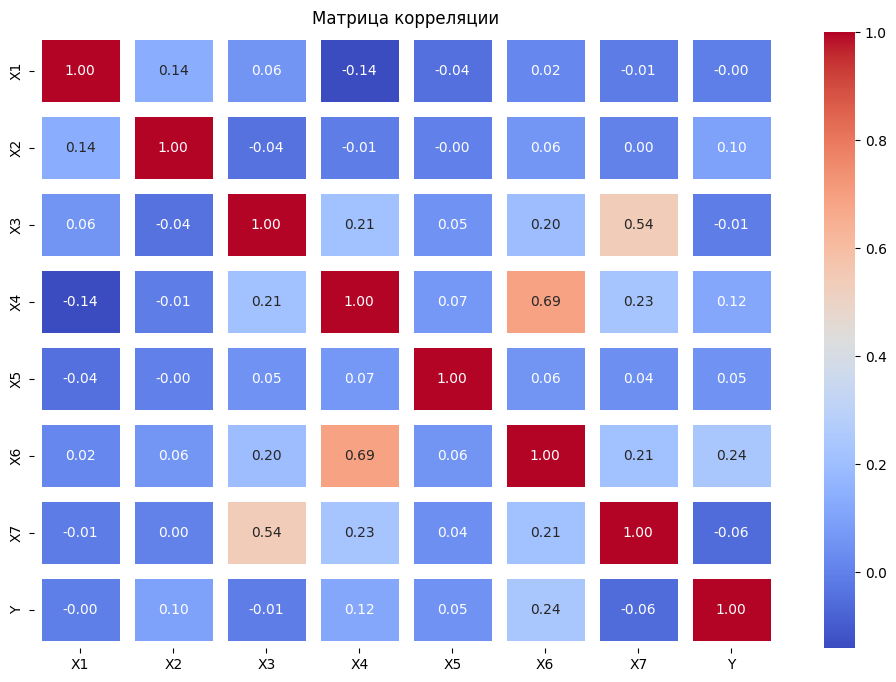

In [9]:
correlation_matrix = data.corr()

# Визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=10.5)
plt.title('Матрица корреляции')
plt.show()

In [10]:
data['X1'].value_counts()

X1
2.0    803
1.0    792
Name: count, dtype: int64

In [11]:
data['X2'].value_counts()

X2
2.0    1302
1.0     292
7.0       1
Name: count, dtype: int64

In [12]:
data['X5'].value_counts()

X5
2.0    1534
3.0      47
1.0      14
Name: count, dtype: int64

Выяснили, что категориальные фичи - X1, X2, X5

Дальше смотрим на boxplot'ы оставшихся фичей на обучающем наборе данных:

<Axes: xlabel='variable', ylabel='value'>

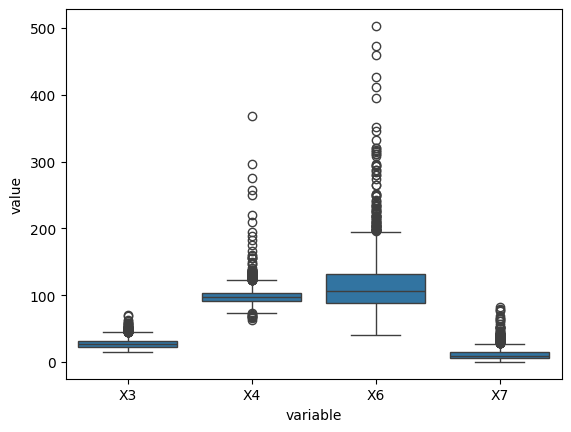

In [13]:
df = pd.DataFrame(data=data, columns=["X3", "X4", "X6", "X7"])
sns.boxplot(x="variable", y="value", data=pd.melt(df))

И на выданном нам открытом наборе:

<Axes: xlabel='variable', ylabel='value'>

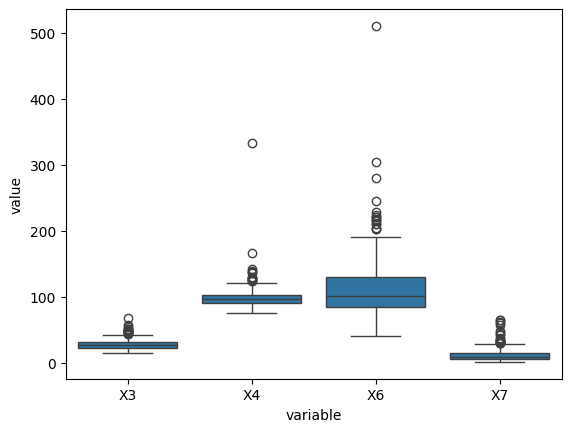

In [14]:
df = pd.DataFrame(data=public_test, columns=["X3", "X4", "X6", "X7"])
sns.boxplot(x="variable", y="value", data=pd.melt(df))

На закрытом наборе:

<Axes: xlabel='variable', ylabel='value'>

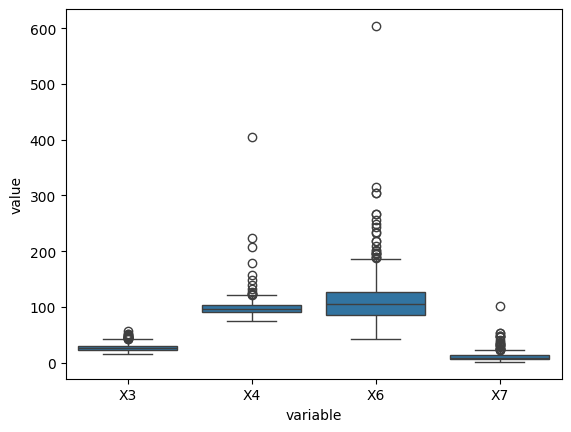

In [15]:
df = pd.DataFrame(data=private_test, columns=["X3", "X4", "X6", "X7"])
sns.boxplot(x="variable", y="value", data=pd.melt(df))

Приняли решение что выбросы удалять не будем, после некоторых тестов стало понятно, что это ухудшает показатели модели

## Обучение модели

### Подготовка данных для обучения

In [16]:
y = data['Y'].copy()

X = data.drop(['Y'],axis = 1)

Из-за несбалансированности классов в таргете используем SMOTE-NC чтобы сгенерировать синтетические данные и уравнять количество экзепляров каждого класса

In [17]:
cat_features=list([0,1,4])
print(cat_features)

[0, 1, 4]


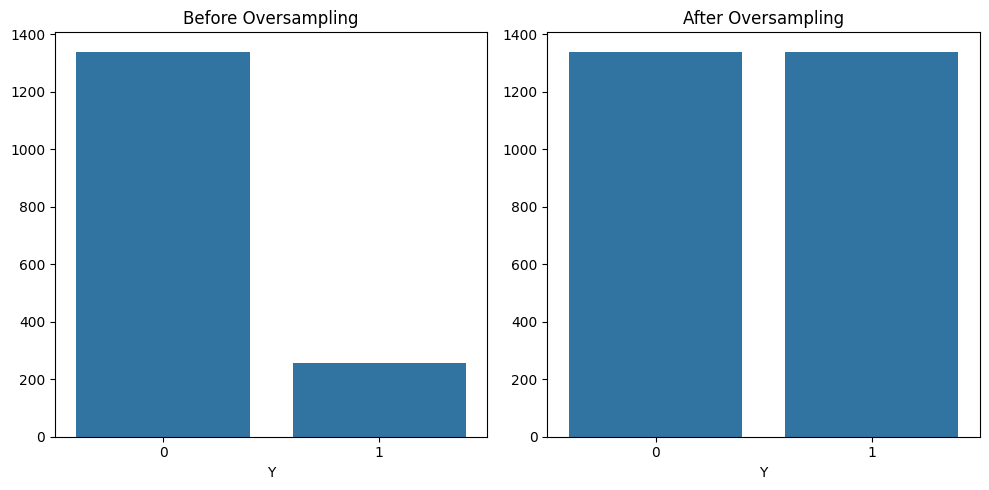

In [18]:
fig, ax = plt.subplots(1,2 ,figsize = (10,5))

sns.barplot(x=['0', '1'], y =[sum(y == 0), sum(y == 1)], ax = ax[0])
ax[0].set_title("Before Oversampling")
ax[0].set_xlabel('Y')

sm = SMOTENC(categorical_features = cat_features, random_state = RAND_STATE) 
X, y = sm.fit_resample(X, y) 

sns.barplot(x=['0', '1'], y =[sum(y == 0), sum(y == 1)], ax = ax[1])
ax[1].set_title("After Oversampling")
ax[1].set_xlabel('Y')

plt.tight_layout()
plt.show()

In [19]:
X['X1'].value_counts()

X1
1.0    1379
2.0    1299
Name: count, dtype: int64

In [20]:
X['X2'].value_counts()

X2
2.0    2385
1.0     292
7.0       1
Name: count, dtype: int64

In [21]:
X['X5'].value_counts()

X5
2.0    2617
3.0      47
1.0      14
Name: count, dtype: int64

In [22]:
X_prepared = X.copy()

In [23]:
X_prepared[['X1','X2','X5']] = X_prepared[['X1','X2','X5']].values.astype(str)

In [24]:
cat_X1 = pd.Categorical(['1.0','2.0'])
cat_X2 = pd.Categorical(['1.0','2.0','7.0'])
cat_X5 = pd.Categorical(['1.0','2.0','3.0'])

In [25]:
X_prepared['X1'] = pd.Categorical(X_prepared['X1'], categories=cat_X1, ordered=True)
X_prepared['X2'] = pd.Categorical(X_prepared['X2'], categories=cat_X2, ordered=True)
X_prepared['X5'] = pd.Categorical(X_prepared['X5'], categories=cat_X5, ordered=True)

In [26]:
X_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2678 entries, 0 to 2677
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      2678 non-null   category
 1   X2      2678 non-null   category
 2   X3      2678 non-null   float64 
 3   X4      2678 non-null   float64 
 4   X5      2678 non-null   category
 5   X6      2678 non-null   float64 
 6   X7      2678 non-null   float64 
dtypes: category(3), float64(4)
memory usage: 92.0 KB


### Разделение данных, настройка параметров модели, обучение

Разделение данных на обучающую и валидационную выборки, настройка гиперпараметров модели CATBoost, обучение модели

In [27]:
X_train, X_validation, y_train, y_validation = train_test_split(X_prepared, y, train_size=0.6, random_state=RAND_STATE, stratify=y)

    iterations=900,                     - сколько деревьев будет построено для бустинга
    loss_function='Logloss',            - функция потерь
    eval_metric= 'F1',                  - какая метрика используется для обнаружения переобучения и выбора лучшей модели
    learning_rate=0.055,                - то, с какой скоростью будет учится модель
    use_best_model=True,                - обычно включена по умолчанию, позволяет не использовать ненужные деревья, после кототорых модель переобучается
    l2_leaf_reg= 21,                    - регуляризация
    boosting_type='Ordered',            - 'Plain' - быстрее, 'Ordered' - лучше показания метрики на маленьких датасетах, а также он выставлен по умолчанию
    bootstrap_type='Bayesian',          - 'Bayesian' - при ранжировании или 'Bernoulli' - обычно при регресси и классификации, есть еще MVS и Poisson. Это влияет на регуляризацию и ускорение при построении деревьев. 
    #subsample=0.5,                     - процент выборки объектов для построения дерева из данных, работает с 'Bernoulli'
    bagging_temperature = 7,            - работает с 'Bayesian', значение для расчета весов объектов в обучении
    one_hot_max_size=3,                 - какое максимальное количество уникальных значений должно быть в колонке, чтобы к этим данным применялся one-hot encoding
    rsm=0.7,                            - количество выбираемых фичей в процентах 
    leaf_estimation_iterations=7,       - регулирует количество шагов, выполняемых в каждом дереве при вычислении значений листьев
    leaf_estimation_method='Newton',    - какой метод будет использоваться для расчета значений в листьях. Есть еще Gradient и Exact
    random_strength                     - множитель дисперсии. Используется для предоствращения переобучения модели, добавляет величину к оценке сплита при обучении. Добавляет рандомности при выборе сплита 

In [28]:
#66.31
model = CatBoostClassifier(
    iterations=900,
    eval_metric= 'F1',
    random_seed = RAND_STATE,
    learning_rate=0.055,
    l2_leaf_reg= 21,
    boosting_type='Ordered',
    bootstrap_type='Bayesian',
    bagging_temperature = 7,
    one_hot_max_size=3,
    rsm=0.7,
    leaf_estimation_iterations=7
)

In [29]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params:
{'iterations': 900, 'learning_rate': 0.055, 'l2_leaf_reg': 21, 'rsm': 0.7, 'leaf_estimation_iterations': 7, 'random_seed': 16, 'one_hot_max_size': 3, 'eval_metric': 'F1', 'bagging_temperature': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}


In [30]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 886


In [31]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,X6,26.282577
1,X3,23.316315
2,X4,21.781122
3,X7,17.092780
4,X2,9.544940
5,X1,1.404273
6,X5,0.577993


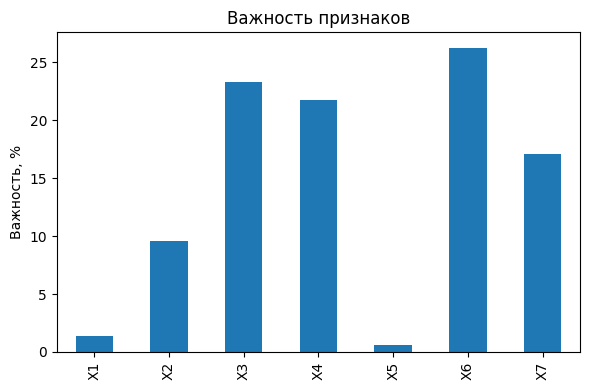

In [32]:
cat_health_imp = pd.Series(model.get_feature_importance(), X_prepared.columns)
                           
fig, ax = plt.subplots(figsize=(6,4))
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
cat_health_imp.plot.bar(ax=ax)
fig.tight_layout()

In [33]:
y_pred = model.predict(X_validation)
print(f1_score(y_validation, y_pred, average='macro'))

0.8007426250179983


### Сохранение обученной модели и ее загрузка 

In [34]:
model.save_model('catboost_model.cbm')

In [35]:
model = CatBoostClassifier()
model.load_model('catboost_model.cbm')

In [36]:
model.get_feature_importance(prettified=True)


,Feature Id,Importances
0,X6,26.282577
1,X3,23.316315
2,X4,21.781122
3,X7,17.092780
4,X2,9.544940
5,X1,1.404273
6,X5,0.577993


## Предсказания на тестовых наборах данных

### На открытом наборе данных

Работаем с public_test таблицей  для предсказания на открытом датасете

In [37]:
public_test.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7'], dtype='object')

In [38]:
X_prepared_pblc = public_test.copy()

In [39]:
X_prepared_pblc[['X1','X2','X5']] = X_prepared_pblc[['X1','X2','X5']].values.astype(str)

In [40]:
X_prepared_pblc['X1'] = pd.Categorical(X_prepared_pblc['X1'], categories=cat_X1, ordered=True)
X_prepared_pblc['X2'] = pd.Categorical(X_prepared_pblc['X2'], categories=cat_X2, ordered=True)
X_prepared_pblc['X5'] = pd.Categorical(X_prepared_pblc['X5'], categories=cat_X5, ordered=True)

In [41]:
X_prepared_pblc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      342 non-null    category
 1   X2      342 non-null    category
 2   X3      342 non-null    float64 
 3   X4      342 non-null    float64 
 4   X5      342 non-null    category
 5   X6      342 non-null    float64 
 6   X7      342 non-null    float64 
dtypes: category(3), float64(4)
memory usage: 12.2 KB


In [42]:
y_pred = model.predict(X_prepared_pblc)

In [43]:
new_pred_pblc = public_test.copy()
new_pred_pblc['Y'] = y_pred
new_pred_pblc

,X1,X2,X3,X4,X5,X6,X7,Y
0,1.0,2.0,27.1,102.0,2.0,130.0,12.08,1
1,2.0,2.0,26.1,84.0,2.0,77.0,3.62,0
2,1.0,2.0,20.5,100.0,2.0,100.0,13.18,0
3,1.0,2.0,33.5,97.0,2.0,105.0,13.61,0
4,1.0,2.0,24.4,106.0,2.0,104.0,8.18,1
...,...,...,...,...,...,...,...,...
337,1.0,2.0,27.0,93.0,2.0,85.0,8.23,0
338,2.0,2.0,23.0,96.0,2.0,129.0,6.80,0
339,1.0,1.0,28.2,92.0,2.0,74.0,6.29,0
340,2.0,2.0,30.4,109.0,2.0,124.0,8.83,1


In [44]:
new_pred_pblc.to_csv('A_pblc_catbst_smotenc.csv',index=False)

### На закрытом наборе данных

Работаем с private_test таблицей  для предсказания на закрытом датасете

In [45]:
private_test.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7'], dtype='object')

In [46]:
X_prepared_prvt = private_test.copy()

In [47]:
X_prepared_prvt[['X1','X2','X5']] = X_prepared_prvt[['X1','X2','X5']].values.astype(str)

In [48]:
X_prepared_prvt['X1'] = pd.Categorical(X_prepared_prvt['X1'], categories=cat_X1, ordered=True)
X_prepared_prvt['X2'] = pd.Categorical(X_prepared_prvt['X2'], categories=cat_X2, ordered=True)
X_prepared_prvt['X5'] = pd.Categorical(X_prepared_prvt['X5'], categories=cat_X5, ordered=True)

In [49]:
X_prepared_prvt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      341 non-null    category
 1   X2      341 non-null    category
 2   X3      341 non-null    float64 
 3   X4      341 non-null    float64 
 4   X5      341 non-null    category
 5   X6      341 non-null    float64 
 6   X7      341 non-null    float64 
dtypes: category(3), float64(4)
memory usage: 12.2 KB


In [50]:
y_pred_prvt = model.predict(X_prepared_prvt)

In [51]:
new_pred_prvt = private_test.copy()
new_pred_prvt['Y'] = y_pred_prvt
new_pred_prvt

,X1,X2,X3,X4,X5,X6,X7,Y
0,1.0,2.0,21.0,86.0,2.0,84.0,4.47,0
1,1.0,2.0,26.5,95.0,2.0,142.0,15.58,1
2,2.0,2.0,37.5,88.0,2.0,78.0,19.20,0
3,1.0,2.0,30.8,102.0,2.0,108.0,12.73,0
4,1.0,2.0,22.2,99.0,2.0,96.0,3.81,0
...,...,...,...,...,...,...,...,...
336,2.0,2.0,20.0,88.0,2.0,91.0,9.40,0
337,1.0,1.0,20.5,93.0,2.0,76.0,6.66,0
338,1.0,1.0,29.7,96.0,2.0,110.0,7.04,0
339,1.0,2.0,48.0,98.0,2.0,83.0,52.64,0


In [52]:
new_pred_prvt.to_csv('A_prvt_catbst_smotenc.csv',index=False)